# 07 — Demo Final (Pipeline complet)

**Objectif :**
- charger une instance (`data/instances/`)
- charger la meilleure solution trouvée (SA) (`data/results/`)
- simuler le planning
- afficher les métriques finales (Cmax, sumT, score)
- générer un **diagramme de Gantt** propre pour le rapport


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path("/content")
INSTANCES_DIR = BASE_DIR / "data" / "instances"
RESULTS_DIR   = BASE_DIR / "data" / "results"
FIG_DIR       = BASE_DIR / "report" / "figures"

FIG_DIR.mkdir(parents=True, exist_ok=True)

print("INSTANCES_DIR:", INSTANCES_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("FIG_DIR:", FIG_DIR)


INSTANCES_DIR: /content/data/instances
RESULTS_DIR: /content/data/results
FIG_DIR: /content/report/figures


## 1) Chargement des fichiers

On charge :
- l’instance (JSON)
- le meilleur résultat du recuit simulé (JSON)



In [2]:
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

instance_path = "/content/data/instances/instance_50jobs_5machines.json"
sa_path = "/content/data/results/best_sa_instance_50jobs_5machines.json"

instance = load_json(instance_path)
sa_out = load_json(sa_path)

print("Instance:", instance["name"])
print("Loaded SA result for:", sa_out["instance"])
print("Params:", sa_out["params"])


Instance: instance_50jobs_5machines
Loaded SA result for: instance_50jobs_5machines
Params: {'n_iters': 5000, 'T0': 1.0, 'cooling': 0.995, 'seed': 0, 'alpha': 1.0, 'beta': 0.2, 'gamma': 0.0}


## 2) Récupération et validation de la solution

La solution est une liste de séquences :
- `solution[k]` = liste des tâches exécutées sur la machine $(k$)



In [3]:
solution = sa_out["best_solution"]

def is_valid_solution(solution, n_jobs):
    flat = [job for seq in solution for job in seq]
    return (len(flat) == n_jobs) and (sorted(flat) == list(range(n_jobs)))

print("Valid solution?", is_valid_solution(solution, instance["n_jobs"]))
print("Machines:", len(solution))
print("Example machine 0:", solution[0][:10], "...")


Valid solution? True
Machines: 5
Example machine 0: [40, 44, 34, 22, 11, 49, 8, 39, 7, 42] ...


## 3) Simulation du planning

On simule l’exécution pour obtenir :
- `start[j]`, `end[j]`
- `Cmax` (makespan)
- puis les métriques (sumT, score)


In [4]:
def simulate(instance, solution):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]
    p = instance["processing_times"]
    releases = instance.get("releases", None)
    if releases is None:
        releases = [0.0] * n_jobs

    start = [0.0] * n_jobs
    end = [0.0] * n_jobs
    machine_time = [0.0] * n_machines

    for k in range(n_machines):
        t = 0.0
        for j in solution[k]:
            t = max(t, float(releases[j]))
            start[j] = t
            t += float(p[j][k])
            end[j] = t
        machine_time[k] = t

    Cmax = max(end) if end else 0.0
    return {"start": start, "end": end, "machine_time": machine_time, "Cmax": Cmax}


In [5]:
def compute_metrics(instance, sim, alpha=1.0, beta=0.2, gamma=0.0):
    end = sim["end"]
    Cmax = float(sim["Cmax"])

    deadlines = instance.get("deadlines", None)
    weights = instance.get("weights", None)

    tardiness = [0.0] * instance["n_jobs"]
    sumT = 0.0
    sumWT = 0.0

    if deadlines is not None:
        for j in range(instance["n_jobs"]):
            tj = max(0.0, float(end[j]) - float(deadlines[j]))
            tardiness[j] = tj
            sumT += tj
            if weights is not None:
                sumWT += float(weights[j]) * tj

    score = alpha * Cmax + beta * sumT + gamma * sumWT
    return {"Cmax": Cmax, "sumT": sumT, "sumWT": sumWT, "score": score, "tardiness": tardiness}


In [6]:
alpha, beta, gamma = 1.0, 0.2, 0.0

sim = simulate(instance, solution)
met = compute_metrics(instance, sim, alpha, beta, gamma)

print("=== FINAL METRICS (SA best) ===")
print("Cmax :", met["Cmax"])
print("sumT :", met["sumT"])
print("score:", met["score"])


=== FINAL METRICS (SA best) ===
Cmax : 53.0
sumT : 0.0
score: 53.0


## 4) Planning final (par machine)

On affiche la séquence de tâches de chaque machine.
Cela permet une inspection qualitative du planning final.


In [7]:
for k, seq in enumerate(solution):
    print(f"Machine {k} | {len(seq)} jobs | sequence:", seq)


Machine 0 | 12 jobs | sequence: [40, 44, 34, 22, 11, 49, 8, 39, 7, 42, 15, 41]
Machine 1 | 9 jobs | sequence: [9, 19, 1, 12, 29, 38, 17, 31, 25]
Machine 2 | 13 jobs | sequence: [35, 10, 48, 6, 28, 3, 16, 27, 43, 4, 26, 21, 46]
Machine 3 | 9 jobs | sequence: [30, 14, 20, 37, 5, 24, 18, 13, 47]
Machine 4 | 7 jobs | sequence: [33, 36, 32, 2, 23, 45, 0]


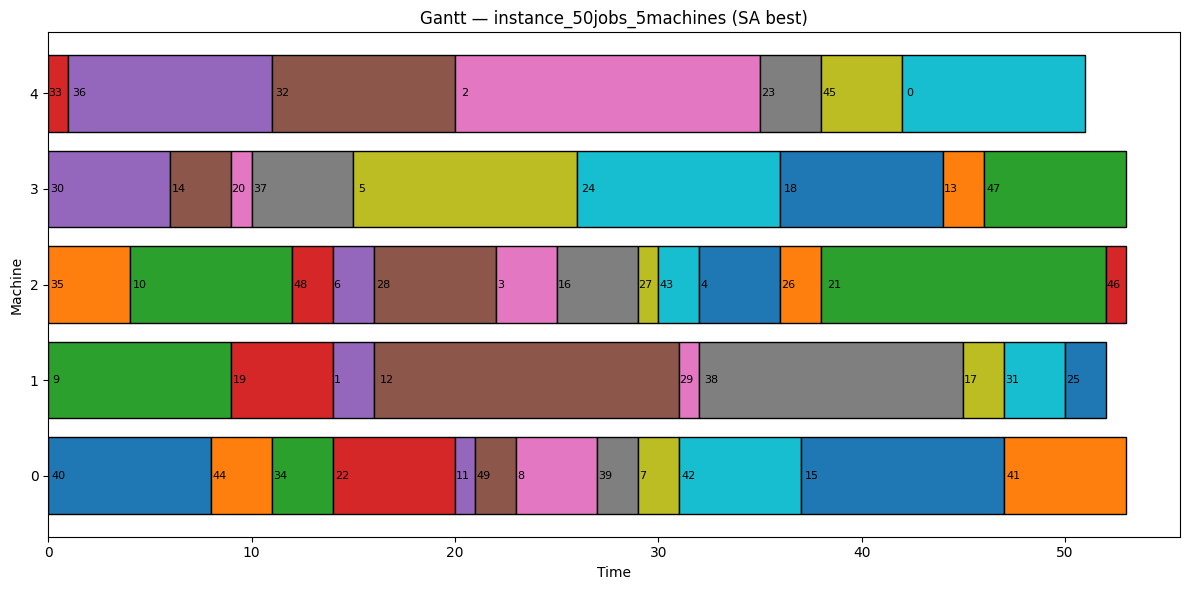

In [8]:
def plot_gantt(instance, solution, sim, title="Gantt chart"):
    start = sim["start"]
    end = sim["end"]

    plt.figure(figsize=(12, 6))
    for k, seq in enumerate(solution):
        for j in seq:
            s = start[j]
            e = end[j]
            plt.barh(y=k, width=e - s, left=s, edgecolor="black")
            # label léger (optionnel) :
            plt.text(s + (e - s) * 0.02, k, str(j), va="center", fontsize=8)

    plt.xlabel("Time")
    plt.ylabel("Machine")
    plt.yticks(range(instance["n_machines"]))
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_gantt(instance, solution, sim, title=f"Gantt — {instance['name']} (SA best)")


## 6) Sauvegarde de la figure

On sauvegarde le Gantt dans `report/figures/` pour l’inclure dans le rapport.


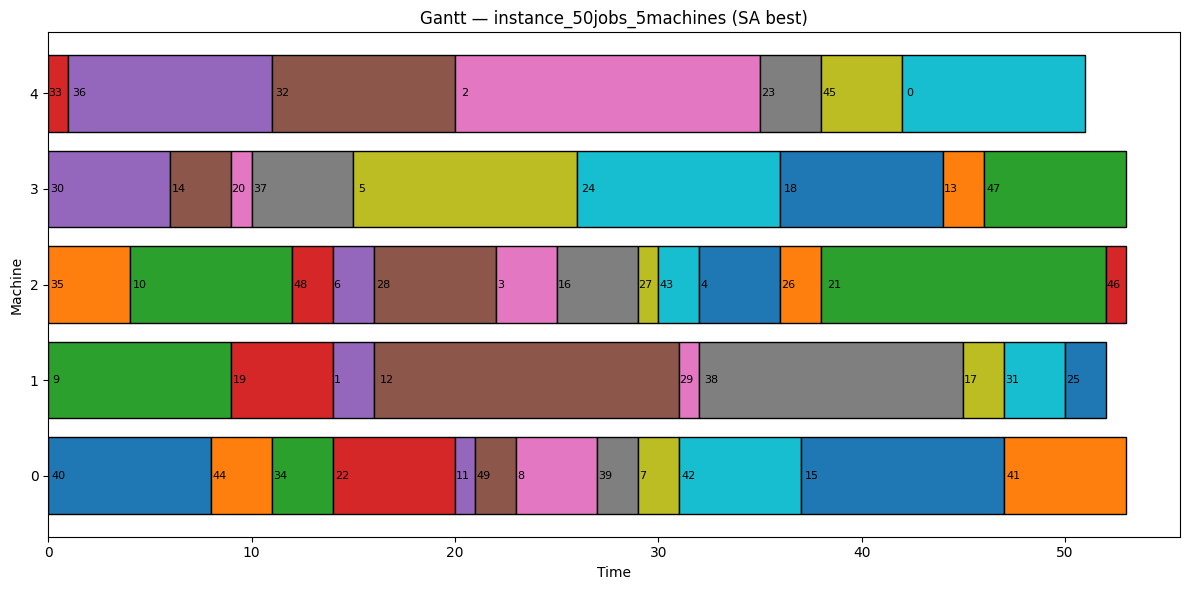

Saved: /content/report/figures/gantt_sa_instance_50jobs_5machines.png


In [9]:
fig_path = FIG_DIR / f"gantt_sa_{instance['name']}.png"

# Replot and save (matplotlib saves the current figure)
plt.figure(figsize=(12, 6))
for k, seq in enumerate(solution):
    for j in seq:
        s = sim["start"][j]
        e = sim["end"][j]
        plt.barh(y=k, width=e - s, left=s, edgecolor="black")
        plt.text(s + (e - s) * 0.02, k, str(j), va="center", fontsize=8)

plt.xlabel("Time")
plt.ylabel("Machine")
plt.yticks(range(instance["n_machines"]))
plt.title(f"Gantt — {instance['name']} (SA best)")
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)


## 8) Analyse finale du planning optimal

Le planning final obtenu par **recuit simulé (Simulated Annealing)** présente
des performances optimales sur l’instance étudiée.

### Analyse des métriques
Les métriques finales sont :
- **Makespan** : $(C_{\max} = 53$)
- **Retard total** : $(sum T_j = 0$)
- **Score global** : 53

Cela signifie que :
- toutes les tâches sont terminées avant leurs deadlines,
- la durée totale de production est minimale parmi les solutions testées,
- le score est dominé uniquement par le makespan, sans pénalité de retard.

### Analyse du diagramme de Gantt
Le diagramme de Gantt met en évidence :
- une **bonne répartition de la charge** entre les machines,
- une utilisation continue des ressources, avec peu de temps d’inactivité,
- un ordonnancement cohérent des tâches longues et courtes,
- l’absence de goulots d’étranglement marqués.

La structure du planning montre que le recuit simulé a su exploiter
des réordonnancements locaux efficaces pour équilibrer les machines
et réduire le makespan global.

### Conclusion générale
Cette démonstration confirme que le **recuit simulé**, en tant que méthode
Monte Carlo guidée, permet d’obtenir des plannings de très haute qualité
pour des problèmes d’ordonnancement complexes.

L’approche combine efficacement :
- exploration aléatoire,
- exploitation locale par voisinages,
- acceptation probabiliste pour éviter les minima locaux.

Elle constitue ainsi une solution robuste, générique et performante,
bien adaptée aux problèmes d’optimisation combinatoire.
